<a href="https://colab.research.google.com/github/donmarcolaureano/predictionofproductsales/blob/main/Preprocessed%20Data%20for%20ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data and imports

In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
# Set pandas as the default output for sklearn
from sklearn import set_config
set_config(transform_output='pandas')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Custom function
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  # Get metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    # Print Result with Label and Header
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics
def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
  # Get predictions for training data
  y_train_pred = reg.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = reg.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )
  # Store results in a dataframe if ouput_frame is True
  if output_frame:
    results_df = pd.DataFrame([results_train,results_test])
    # Set the label as the index
    results_df = results_df.set_index('Label')
    # Set index.name to none to get a cleaner looking result
    results_df.index.name=None
    # Return the dataframe
    return results_df.round(3)


In [4]:
# Data
df = pd.read_csv('/content/drive/MyDrive/CodingDojo/01-Fundamentals/Week02/Data/sales_predictions_2023.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# EDA

In [5]:
# Dtypes
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [6]:
# Duplicated rows
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
8518    False
8519    False
8520    False
8521    False
8522    False
Length: 8523, dtype: bool

In [7]:
# Null values
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [8]:
# make copy of original df to avoid any manipulations
eda_df = df.copy()

In [9]:
# drop unnecessary columns
eda_df = eda_df.drop('Item_Identifier', axis=1)

In [10]:
# display first 5 rows

eda_df.head(5)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# Define Target & Features and Train Test Split

In [11]:
# define target and featgures
target = 'Item_Outlet_Sales'
y = eda_df[target]
X = eda_df.drop(columns=[target, 'Item_Outlet_Sales'])

In [12]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [13]:
# Inspect X_train
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6392 entries, 4776 to 7270
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                5285 non-null   float64
 1   Item_Fat_Content           6392 non-null   object 
 2   Item_Visibility            6392 non-null   float64
 3   Item_Type                  6392 non-null   object 
 4   Item_MRP                   6392 non-null   float64
 5   Outlet_Identifier          6392 non-null   object 
 6   Outlet_Establishment_Year  6392 non-null   int64  
 7   Outlet_Size                4580 non-null   object 
 8   Outlet_Location_Type       6392 non-null   object 
 9   Outlet_Type                6392 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 549.3+ KB


# Create 3 Pipelines

## Ordinal

In [14]:
# Save list
ord_cols = ['Outlet_Size']

In [15]:
# Impute null values usting strategy most_frequent
impute_na_ord = SimpleImputer(strategy = 'most_frequent')

In [16]:
# ordinal encoder for outlet size
size_order = ['Small', 'Medium', 'High']
size_encoder = OrdinalEncoder(categories=[size_order])
size_encoder

OrdinalEncoder(categories=[['Small', 'Medium', 'High']])

In [17]:
# Scaler
scaler = StandardScaler()

In [18]:
# pipeline
ord_pipeline = make_pipeline(impute_na_ord, size_encoder, scaler)
ord_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['Small', 'Medium', 'High']])),
                ('standardscaler', StandardScaler())])

In [19]:
# ordinal tuple
ord_tuple = ('ordinal', ord_pipeline, ord_cols)
ord_tuple

('ordinal',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                 ('ordinalencoder',
                  OrdinalEncoder(categories=[['Small', 'Medium', 'High']])),
                 ('standardscaler', StandardScaler())]),
 ['Outlet_Size'])

## Numerical

In [20]:
# save list of numeric features
num_cols = X_train.select_dtypes('number').columns
num_cols

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')

In [21]:
# impute nan values with SimpleImputer strategy median
impute_mean = SimpleImputer(strategy='mean')

In [22]:
# Scaler
scaler = StandardScaler()

In [23]:
# make pipeline
num_pipe = make_pipeline(impute_mean, scaler)
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [24]:
# numerical tuple
num_tuple = ('numeric', num_pipe, num_cols)
num_tuple

('numeric',
 Pipeline(steps=[('simpleimputer', SimpleImputer()),
                 ('standardscaler', StandardScaler())]),
 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
        'Outlet_Establishment_Year'],
       dtype='object'))

## Categorical

In [25]:
# Save list of nominal features
cat_cols = X_train.select_dtypes('object').drop(columns=ord_cols).columns
cat_cols

Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [26]:
# OneHotEncoder
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

In [27]:
# Pipeline
cat_pipe = make_pipeline(ohe_encoder)
cat_pipe

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [28]:
# Categorical tuple
cat_tuple = ('categorical', cat_pipe, cat_cols)
cat_tuple

('categorical',
 Pipeline(steps=[('onehotencoder',
                  OneHotEncoder(handle_unknown='ignore', sparse_output=False))]),
 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
        'Outlet_Location_Type', 'Outlet_Type'],
       dtype='object'))

# Column Transformer

In [29]:
# Instantiate column transformer
col_transformer = ColumnTransformer ([num_tuple, cat_tuple, ord_tuple], verbose_feature_names_out=False)
col_transformer

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Small',
                                                                              'Medium',
                                                                              'High']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Outlet_Size'])],
                  verbose_feature_names_out=False)

In [30]:
# Fit the column transformer
col_transformer.fit(X_train)

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Small',
                                                                              'Medium',
                                                                              'High']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Outlet_Size'])],
                  verbose_feature_names_out=False)

In [31]:
# Save transformed data
X_train_processed = col_transformer.transform(X_train)
X_train_processed.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_LF,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,Item_Type_Baking Goods,...,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Size
4776,0.817249,-0.712775,1.828109,1.327849,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.287374
7510,0.556340,-1.291052,0.603369,1.327849,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.287374
5828,-0.131512,1.813319,0.244541,0.136187,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.287374
5327,-1.169219,-1.004931,-0.952591,0.732018,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-1.384048
4810,1.528819,-0.965484,-0.336460,0.493686,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.287374


In [32]:
#Process X_test
X_test_processed = col_transformer.transform(X_test)
X_test_processed.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_LF,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,Item_Type_Baking Goods,...,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Size
7503,3.310089e-01,-0.776646,-0.998816,-1.293807,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.958796
2957,-1.179892e+00,0.100317,-1.585194,-0.102145,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.384048
7031,3.784469e-01,-0.482994,-1.595784,0.136187,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.287374
1084,4.213344e-16,-0.415440,0.506592,-1.532139,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.287374
856,-6.426567e-01,-1.047426,0.886725,0.732018,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-1.384048


# CRISP-DM Phase 4 - Modeling

## Linear Regression Model

In [33]:
# Instantiate model
lin_reg = LinearRegression()
lin_reg

LinearRegression()

In [34]:
# fit on training data
lin_reg.fit(X_train_processed, y_train)

LinearRegression()

In [35]:
# Get predictions for training data
y_preds_train = lin_reg.predict(X_train_processed)
# Get predictions for the testing data
y_preds_test = lin_reg.predict(X_test_processed)

In [36]:
# Evaluate model
evaluate_regression(lin_reg, X_train_processed, y_train, X_test_processed, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 847.154
- MSE = 1,297,212.367
- RMSE = 1,138.952
- R^2 = 0.562

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 804.225
- MSE = 1,194,696.265
- RMSE = 1,093.022
- R^2 = 0.567


This model is very underfit. The R^2 shows that it can only explain ~57% of the variation in the target

## Random Forest Model

In [37]:
# Instantiate default random forest model
rf = RandomForestRegressor(random_state=42)

In [38]:
# Model pipeline
rf_pipe = make_pipeline(col_transformer, rf)

In [39]:
# fit pipeline on training data
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',...
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Small',
                                                                                               'Medium',
                                                                                               'High']])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Outlet_Size'])],
                                   verbose_feature_names_out=False)),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [40]:
# Evaluate
evaluate_regression(rf_pipe, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 296.833
- MSE = 182,935.361
- RMSE = 427.709
- R^2 = 0.938

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 763.708
- MSE = 1,213,209.449
- RMSE = 1,101.458
- R^2 = 0.560


The Random Forest model did significantly better than the Linear Regression model on the training data but did slightly worse on the testing data

## GridSearchCV for tuning

In [41]:
# Parameters for tuning
rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
          'Outlet_Establishment_Year'],
         dtype='object')),
                                   ('categorical',
                                    Pipeline(steps=[('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse_output=False))]),
                                    Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
          'Outlet_Location_Type', 'Outlet_Type'],
         

In [42]:
# define param grid with options to try
params = {'randomforestregressor__max_features': [1, 2, 3, 4, 5, 6, 7, 8], 'randomforestregressor__min_samples_leaf': [1, 2, 3], 'randomforestregressor__min_samples_split': [1, 2, 3]}

In [43]:
# Instantiate the gridsearch
gridsearch = GridSearchCV(rf_pipe, params, n_jobs = -1, cv = 4, verbose = 1)

In [44]:
# Fit gridsearch on training data
gridsearch.fit(X_train, y_train)

Fitting 4 folds for each of 72 candidates, totalling 288 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
96 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
96 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packa

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEnco...
                                                                                                                      'High']])),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['Outlet_Size'])],
                                                          verbose_feature_names_out=False)),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_features': [1, 2, 3, 4, 5,
                                                                 6, 7, 8],
                         'randomforestregressor__min_samples_leaf': [1, 2, 3],
                         'randomforestregressor__min_samples_split': [1, 2, 3]},
             verbose=1)

In [45]:
# Obtain best parameters
gridsearch.best_params_

{'randomforestregressor__max_features': 8,
 'randomforestregressor__min_samples_leaf': 3,
 'randomforestregressor__min_samples_split': 2}

In [46]:
# define and refit best model
best_rf = gridsearch.best_estimator_
evaluate_regression(best_rf, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 612.300
- MSE = 760,039.172
- RMSE = 871.802
- R^2 = 0.743

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 745.397
- MSE = 1,123,885.344
- RMSE = 1,060.135
- R^2 = 0.593


# CRISP-DM Phase 5

Based off of the different models, I would recommend using the tuned Random Forest model as it outperformed both the Linear Regression and default Random Forest model on MAE, MSE, RMSE, and R^2 for the testing data
- Despite the Linear Regression model and Default Random Forest model having large differences in the training data, they both performed fairly similar on the test data
- The tuned Random Forest model is very comparable to the Default Random Forest model in many ways. The Default model actually outperformed the Tuned model in the training data but fell short on the data that mattered, the test data.

The R^2 metric is very important. It shows that the model can explain a specific % of the data.
- The Linear Regression model can explain ~57% of the test data
- The Default Random Forest model can explain 56% of the test data
- The Tuned Random Forest model can explain for 59% of the test data


We will also look at the RMSE to compare the differences in models
- The Linear Regression model had an RMSE of 1093.022
- The Default Random Forest model has an RMSE of 1101.458
- The Tuned Random Forest model had an RMSE of 1063.506
  - RMSE was -37.952 from the Default Random Forest model
  - RMSE was -29.516 from the Linear Regression model

Every model is underfit but the Tuned Random Forest model is the least underfit of the three models we compared and it performed better for all the metrics on the testing data.

This is a starting point and there is always room for improvement through adding more data, increasing complexity, or adding features with higher correlations to the target

# Revisit Models

In [67]:
SEED = 321
np.random.seed(SEED)
from sklearn.inspection import permutation_importance

In [48]:
# Get feature names
feature_names = col_transformer.get_feature_names_out()
feature_names

array(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Fat_Content_LF',
       'Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular',
       'Item_Fat_Content_low fat', 'Item_Fat_Content_reg',
       'Item_Type_Baking Goods', 'Item_Type_Breads',
       'Item_Type_Breakfast', 'Item_Type_Canned', 'Item_Type_Dairy',
       'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables',
       'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene',
       'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Others',
       'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Identifier_OUT010', 'Outlet_Identifier_OUT013',
       'Outlet_Identifier_OUT017', 'Outlet_Identifier_OUT018',
       'Outlet_Identifier_OUT019', 'Outlet_Identifier_OUT027',
       'Outlet_Identifier_OUT035', 'Outlet_Identifier_OUT045',
       'Outlet_Identifier_OUT046', 'Outlet_Identifier_OUT049',
       'Outlet_Lo

In [49]:
# Remake X_train and X_test as DataFrames with new feature names
X_train_2 = pd.DataFrame(col_transformer.transform(X_train),columns = feature_names, index = X_train.index)
X_test_2 = pd.DataFrame(col_transformer.transform(X_test), columns= feature_names, index = X_test.index)

In [50]:
X_train_2.head(3)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_LF,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,Item_Type_Baking Goods,...,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Size
4776,0.817249,-0.712775,1.828109,1.327849,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.287374
7510,0.556340,-1.291052,0.603369,1.327849,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.287374
5828,-0.131512,1.813319,0.244541,0.136187,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.287374


In [51]:
X_test_2.head(3)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_LF,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,Item_Type_Baking Goods,...,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Size
7503,0.331009,-0.776646,-0.998816,-1.293807,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.958796
2957,-1.179892,0.100317,-1.585194,-0.102145,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.384048
7031,0.378447,-0.482994,-1.595784,0.136187,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.287374


### Tree Based Model

In [52]:
reg_seed = RandomForestRegressor(random_state=SEED)
reg_seed.fit(X_train_2, y_train)
evaluate_regression(reg_seed, X_train_2, y_train, X_test_2, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 297.885
- MSE = 183,458.648
- RMSE = 428.321
- R^2 = 0.938

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 767.654
- MSE = 1,217,538.621
- RMSE = 1,103.421
- R^2 = 0.559


In [53]:
# Get Feature importances
reg_seed.feature_importances_

array([5.16832113e-02, 9.60471732e-02, 4.38233495e-01, 2.73535320e-02,
       3.41752926e-03, 6.33338376e-03, 6.25707219e-03, 1.70519691e-03,
       1.68939456e-03, 4.18829615e-03, 2.47581108e-03, 2.85962424e-03,
       4.26900171e-03, 6.38320192e-03, 5.76235991e-03, 7.55947787e-03,
       2.95837295e-03, 3.78933206e-03, 6.13602667e-03, 3.63732302e-03,
       1.56341704e-03, 1.74766231e-03, 8.31422126e-03, 5.63018047e-03,
       3.14457962e-03, 1.28815876e-05, 1.71353338e-03, 3.67188785e-03,
       1.20336672e-03, 1.58436153e-05, 2.68116835e-02, 4.00209734e-03,
       4.51138014e-03, 3.57462891e-03, 4.16470939e-03, 3.48577182e-03,
       3.09152990e-03, 2.94084796e-03, 1.91709016e-01, 1.79416087e-03,
       1.32596713e-03, 3.67647099e-02, 6.06710836e-03])

In [54]:
# Save the feature importances
tree_importances = pd.Series(reg_seed.feature_importances_, index = feature_names, name = 'Feature Importance')
tree_importances

Item_Weight                        0.051683
Item_Visibility                    0.096047
Item_MRP                           0.438233
Outlet_Establishment_Year          0.027354
Item_Fat_Content_LF                0.003418
Item_Fat_Content_Low Fat           0.006333
Item_Fat_Content_Regular           0.006257
Item_Fat_Content_low fat           0.001705
Item_Fat_Content_reg               0.001689
Item_Type_Baking Goods             0.004188
Item_Type_Breads                   0.002476
Item_Type_Breakfast                0.002860
Item_Type_Canned                   0.004269
Item_Type_Dairy                    0.006383
Item_Type_Frozen Foods             0.005762
Item_Type_Fruits and Vegetables    0.007559
Item_Type_Hard Drinks              0.002958
Item_Type_Health and Hygiene       0.003789
Item_Type_Household                0.006136
Item_Type_Meat                     0.003637
Item_Type_Others                   0.001563
Item_Type_Seafood                  0.001748
Item_Type_Snack Foods           

In [55]:
# Saving the feature importances sorted from smallest to largest (ascending=True)
sorted_trees = tree_importances.sort_values()
sorted_trees

Outlet_Identifier_OUT010           0.000013
Outlet_Identifier_OUT019           0.000016
Outlet_Identifier_OUT018           0.001203
Outlet_Type_Supermarket Type2      0.001326
Item_Type_Others                   0.001563
Item_Fat_Content_reg               0.001689
Item_Fat_Content_low fat           0.001705
Outlet_Identifier_OUT013           0.001714
Item_Type_Seafood                  0.001748
Outlet_Type_Supermarket Type1      0.001794
Item_Type_Breads                   0.002476
Item_Type_Breakfast                0.002860
Outlet_Location_Type_Tier 3        0.002941
Item_Type_Hard Drinks              0.002958
Outlet_Location_Type_Tier 2        0.003092
Item_Type_Starchy Foods            0.003145
Item_Fat_Content_LF                0.003418
Outlet_Location_Type_Tier 1        0.003486
Outlet_Identifier_OUT046           0.003575
Item_Type_Meat                     0.003637
Outlet_Identifier_OUT017           0.003672
Item_Type_Health and Hygiene       0.003789
Outlet_Identifier_OUT035        

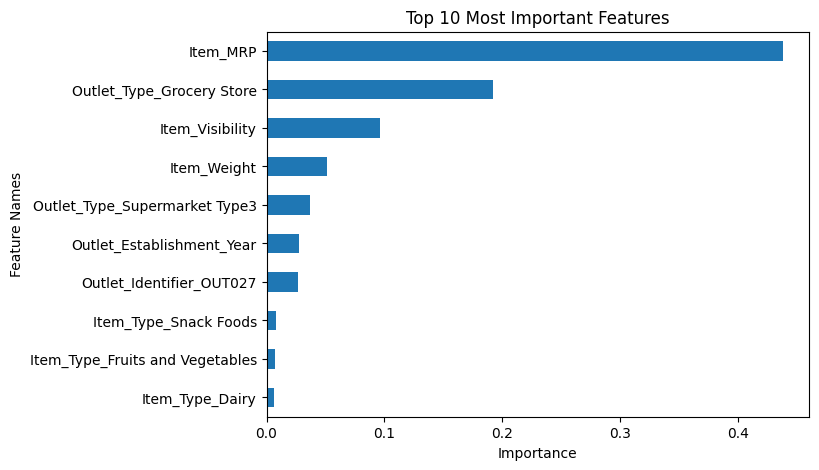

In [56]:
# Visualization of importances
ax = sorted_trees.tail(10).plot(kind='barh', figsize=(7,5),)
ax.set(xlabel='Importance',
        ylabel='Feature Names',
        title='Top 10 Most Important Features');

The top 5 most important features are:

1) Item MRP

2) Outlet Type - Grocery Store

3) Item Visibility

4) Item Weight

5) Outlet Type - Supermarket

### Linear Regression

In [57]:
lin_reg.fit(X_train_2, y_train)
evaluate_regression(lin_reg, X_train_2, y_train, X_test_2, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 847.154
- MSE = 1,297,212.367
- RMSE = 1,138.952
- R^2 = 0.562

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 804.225
- MSE = 1,194,696.265
- RMSE = 1,093.022
- R^2 = 0.567


In [58]:
# Get Coefficients
lin_reg.coef_

array([-8.37242850e+00, -2.19094518e+01,  9.84158452e+02, -1.41827843e+15,
        1.31577833e+14,  1.31577833e+14,  1.31577833e+14,  1.31577833e+14,
        1.31577833e+14, -7.84378216e+13, -7.84378216e+13, -7.84378216e+13,
       -7.84378216e+13, -7.84378216e+13, -7.84378216e+13, -7.84378216e+13,
       -7.84378216e+13, -7.84378216e+13, -7.84378216e+13, -7.84378216e+13,
       -7.84378216e+13, -7.84378216e+13, -7.84378216e+13, -7.84378216e+13,
       -7.84378216e+13, -5.94175480e+12, -1.09656306e+15, -3.75156549e+14,
        9.22152018e+14, -1.20608015e+15, -1.20819872e+15, -1.44695140e+15,
       -1.22021058e+15,  1.02578468e+15,  1.92856872e+15, -5.20069715e+14,
        3.13574201e+15,  1.04169481e+15, -1.91553696e+14, -3.95288839e+14,
        7.39471408e+14, -1.18643722e+15, -3.37893380e+14])

In [59]:
# Saving the coefficients as a pandas series
coeffs = pd.Series(lin_reg.coef_, index = feature_names)
coeffs

Item_Weight                       -8.372429e+00
Item_Visibility                   -2.190945e+01
Item_MRP                           9.841585e+02
Outlet_Establishment_Year         -1.418278e+15
Item_Fat_Content_LF                1.315778e+14
Item_Fat_Content_Low Fat           1.315778e+14
Item_Fat_Content_Regular           1.315778e+14
Item_Fat_Content_low fat           1.315778e+14
Item_Fat_Content_reg               1.315778e+14
Item_Type_Baking Goods            -7.843782e+13
Item_Type_Breads                  -7.843782e+13
Item_Type_Breakfast               -7.843782e+13
Item_Type_Canned                  -7.843782e+13
Item_Type_Dairy                   -7.843782e+13
Item_Type_Frozen Foods            -7.843782e+13
Item_Type_Fruits and Vegetables   -7.843782e+13
Item_Type_Hard Drinks             -7.843782e+13
Item_Type_Health and Hygiene      -7.843782e+13
Item_Type_Household               -7.843782e+13
Item_Type_Meat                    -7.843782e+13
Item_Type_Others                  -7.843

In [60]:
pd.set_option('display.float_format', lambda x: f"{x:,.2f}")
coeffs


Item_Weight                                           -8.37
Item_Visibility                                      -21.91
Item_MRP                                             984.16
Outlet_Establishment_Year         -1,418,278,428,679,293.50
Item_Fat_Content_LF                  131,577,833,027,117.17
Item_Fat_Content_Low Fat             131,577,833,027,175.64
Item_Fat_Content_Regular             131,577,833,027,240.14
Item_Fat_Content_low fat             131,577,833,027,237.06
Item_Fat_Content_reg                 131,577,833,027,132.33
Item_Type_Baking Goods               -78,437,821,559,223.02
Item_Type_Breads                     -78,437,821,559,252.25
Item_Type_Breakfast                  -78,437,821,559,178.05
Item_Type_Canned                     -78,437,821,559,196.89
Item_Type_Dairy                      -78,437,821,559,331.45
Item_Type_Frozen Foods               -78,437,821,559,225.06
Item_Type_Fruits and Vegetables      -78,437,821,559,177.78
Item_Type_Hard Drinks                -78

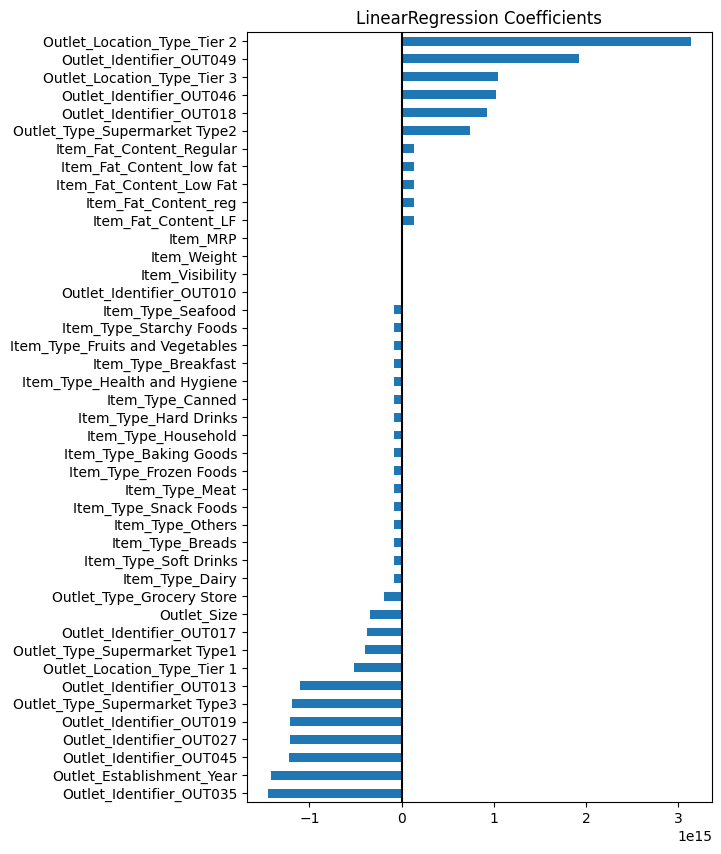

In [61]:
## Plot the coefficients
ax = coeffs.sort_values().plot(kind='barh',figsize=(6,10))
ax.axvline(0,color='k')
ax.set_title('LinearRegression Coefficients');

In [62]:
coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
coeff_rank

Outlet_Location_Type_Tier 2       43.00
Outlet_Identifier_OUT049          42.00
Outlet_Identifier_OUT035          41.00
Outlet_Establishment_Year         40.00
Outlet_Identifier_OUT045          39.00
Outlet_Identifier_OUT027          38.00
Outlet_Identifier_OUT019          37.00
Outlet_Type_Supermarket Type3     36.00
Outlet_Identifier_OUT013          35.00
Outlet_Location_Type_Tier 3       34.00
Outlet_Identifier_OUT046          33.00
Outlet_Identifier_OUT018          32.00
Outlet_Type_Supermarket Type2     31.00
Outlet_Location_Type_Tier 1       30.00
Outlet_Type_Supermarket Type1     29.00
Outlet_Identifier_OUT017          28.00
Outlet_Size                       27.00
Outlet_Type_Grocery Store         26.00
Item_Fat_Content_Regular          25.00
Item_Fat_Content_low fat          24.00
Item_Fat_Content_Low Fat          23.00
Item_Fat_Content_reg              22.00
Item_Fat_Content_LF               21.00
Item_Type_Dairy                   20.00
Item_Type_Soft Drinks             19.00


In [63]:
top_n_features = coeff_rank.head(5)
top_n_features

Outlet_Location_Type_Tier 2   43.00
Outlet_Identifier_OUT049      42.00
Outlet_Identifier_OUT035      41.00
Outlet_Establishment_Year     40.00
Outlet_Identifier_OUT045      39.00
dtype: float64

In [64]:
# Get top n_features to visualize
plot_vals = coeffs.loc[top_n_features.index]
plot_vals

Outlet_Location_Type_Tier 2    3,135,742,007,298,977.50
Outlet_Identifier_OUT049       1,928,568,718,537,006.75
Outlet_Identifier_OUT035      -1,446,951,395,439,056.00
Outlet_Establishment_Year     -1,418,278,428,679,293.50
Outlet_Identifier_OUT045      -1,220,210,583,287,014.50
dtype: float64

In [65]:
top_n = 10
coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
top_n_features = coeff_rank.head(top_n).index
plot_vals = coeffs.loc[top_n_features].sort_values()
plot_vals


Outlet_Identifier_OUT035        -1,446,951,395,439,056.00
Outlet_Establishment_Year       -1,418,278,428,679,293.50
Outlet_Identifier_OUT045        -1,220,210,583,287,014.50
Outlet_Identifier_OUT027        -1,208,198,720,998,586.50
Outlet_Identifier_OUT019        -1,206,080,147,221,315.00
Outlet_Type_Supermarket Type3   -1,186,437,219,504,717.00
Outlet_Identifier_OUT013        -1,096,563,062,071,492.75
Outlet_Location_Type_Tier 3      1,041,694,808,260,494.12
Outlet_Identifier_OUT049         1,928,568,718,537,006.75
Outlet_Location_Type_Tier 2      3,135,742,007,298,977.50
dtype: float64

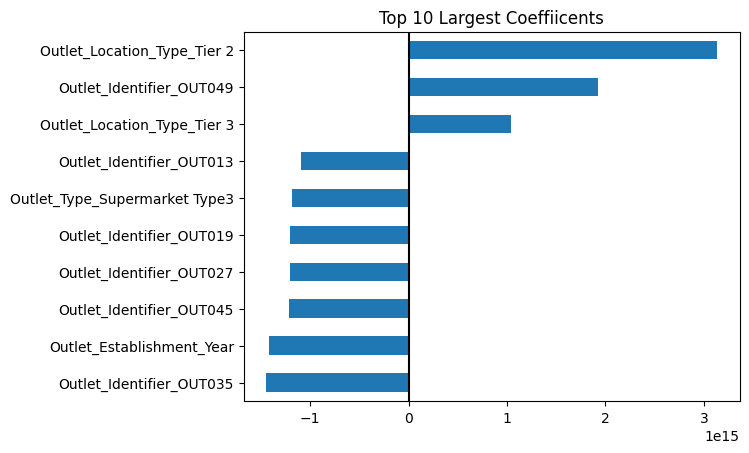

In [66]:
## Plot the coefficients
ax = plot_vals.sort_values().plot(kind='barh')#,figsize=(5,6))
ax.axvline(0,color='k')
ax.set_title(f'Top {top_n} Largest Coeffiicents');

# The top three most imporant coefficients are:

1) Outlet Location Type - Tier 2

2) Outlet Identifier - OUT049

3) Outlet Location Type - Tier 3